<a href="https://colab.research.google.com/github/sumanurawat/bert-optimization/blob/main/notebooks/BERT_Baseline_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ No GPU detected - check runtime settings!")


PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA version: 12.6
GPU: Tesla T4
GPU Memory: 15.83 GB


In [16]:
# Install required packages
!pip install -q transformers==4.44.0
!pip install -q accelerate==0.34.0
!pip install -q datasets==2.21.0
!pip install -q sentencepiece==0.2.0

print("✅ All packages installed!")

✅ All packages installed!


In [17]:
import torch
from transformers import AutoTokenizer, AutoModel
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("✅ All imports successful!")

✅ All imports successful!


In [18]:
# Load BERT model and tokenizer
print("📥 Loading BERT-base-uncased...")

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

print(f"✅ Model loaded: {model_name}")
print(f"📊 Model size: {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

📥 Loading BERT-base-uncased...


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

✅ Model loaded: bert-base-uncased
📊 Model size: 109.5M parameters


In [19]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✅ Model moved to: {device}")
print(f"🎯 Model is on GPU: {next(model.parameters()).is_cuda}")

✅ Model moved to: cuda
🎯 Model is on GPU: True


In [20]:
# See what the 14 tokens are
test_text = "This is a test sentence to measure BERT inference latency."

# Tokenize and see tokens
inputs = tokenizer(test_text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print(f"Original text: {test_text}")
print(f"\nNumber of tokens: {len(tokens)}")
print(f"\nTokens breakdown:")
for i, token in enumerate(tokens):
    print(f"  {i}: '{token}'")

print(f"\nOutput shape: [batch_size, num_tokens, embedding_dim]")
print(f"             = [1, {len(tokens)}, 768]")

Original text: This is a test sentence to measure BERT inference latency.

Number of tokens: 14

Tokens breakdown:
  0: '[CLS]'
  1: 'this'
  2: 'is'
  3: 'a'
  4: 'test'
  5: 'sentence'
  6: 'to'
  7: 'measure'
  8: 'bert'
  9: 'inference'
  10: 'late'
  11: '##ncy'
  12: '.'
  13: '[SEP]'

Output shape: [batch_size, num_tokens, embedding_dim]
             = [1, 14, 768]


In [21]:
# Test single inference
test_text = "This is a test sentence to measure BERT inference latency."

# Tokenize
inputs = tokenizer(test_text, return_tensors="pt", padding=True, truncation=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

print("✅ Single inference successful!")
print(f"📊 Output shape: {outputs.last_hidden_state.shape}")

✅ Single inference successful!
📊 Output shape: torch.Size([1, 14, 768])


In [22]:
# Warm-up: Run model a few times to stabilize GPU
print("🔥 Warming up GPU...")

for i in range(10):
    with torch.no_grad():
        _ = model(**inputs)
    if (i + 1) % 5 == 0:
        print(f"   Warm-up: {i+1}/10")

print("✅ Warm-up complete!")

🔥 Warming up GPU...
   Warm-up: 5/10
   Warm-up: 10/10
✅ Warm-up complete!


In [23]:
# Benchmark baseline latency
print("⏱️  Measuring baseline latency...")

num_runs = 100
latencies = []

for i in tqdm(range(num_runs), desc="Benchmarking"):
    start = time.time()
    with torch.no_grad():
        _ = model(**inputs)
    torch.cuda.synchronize()  # Wait for GPU to finish
    end = time.time()
    latencies.append((end - start) * 1000)  # Convert to milliseconds

# Calculate statistics
avg_latency = np.mean(latencies)
std_latency = np.std(latencies)
p50_latency = np.percentile(latencies, 50)
p95_latency = np.percentile(latencies, 95)
p99_latency = np.percentile(latencies, 99)

print("\n" + "="*50)
print("📊 BASELINE RESULTS (FP32)")
print("="*50)
print(f"Average Latency: {avg_latency:.2f} ms")
print(f"Std Dev:         {std_latency:.2f} ms")
print(f"P50 (Median):    {p50_latency:.2f} ms")
print(f"P95:             {p95_latency:.2f} ms")
print(f"P99:             {p99_latency:.2f} ms")
print(f"Min:             {min(latencies):.2f} ms")
print(f"Max:             {max(latencies):.2f} ms")
print("="*50)

⏱️  Measuring baseline latency...


Benchmarking: 100%|██████████| 100/100 [00:01<00:00, 56.55it/s]


📊 BASELINE RESULTS (FP32)
Average Latency: 17.40 ms
Std Dev:         9.28 ms
P50 (Median):    13.87 ms
P95:             34.93 ms
P99:             45.67 ms
Min:             7.09 ms
Max:             62.63 ms


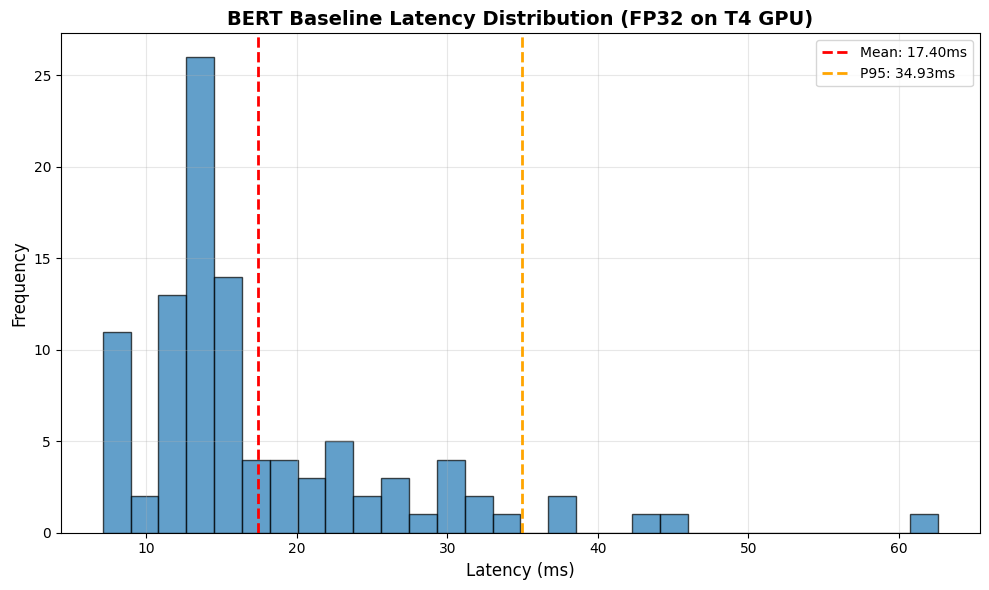

✅ Chart saved as bert_baseline_latency.png


In [24]:
# Plot latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(avg_latency, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_latency:.2f}ms')
plt.axvline(p95_latency, color='orange', linestyle='--', linewidth=2, label=f'P95: {p95_latency:.2f}ms')
plt.xlabel('Latency (ms)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('BERT Baseline Latency Distribution (FP32 on T4 GPU)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bert_baseline_latency.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Chart saved as bert_baseline_latency.png")

In [25]:
# Benchmark throughput (sentences per second)
print("🚀 Measuring throughput...")

# Prepare batch of sentences
batch_texts = [
    "This is sentence 1.",
    "Here is another test sentence.",
    "BERT processes multiple sentences.",
    "Machine learning is awesome.",
] * 8  # 32 sentences total

# Tokenize batch
batch_inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}

# Warm-up
for _ in range(5):
    with torch.no_grad():
        _ = model(**batch_inputs)

# Measure
num_batches = 50
start = time.time()

for _ in tqdm(range(num_batches), desc="Throughput test"):
    with torch.no_grad():
        _ = model(**batch_inputs)
    torch.cuda.synchronize()

end = time.time()

total_sentences = len(batch_texts) * num_batches
total_time = end - start
throughput = total_sentences / total_time

print("\n" + "="*50)
print("📊 THROUGHPUT RESULTS")
print("="*50)
print(f"Total sentences: {total_sentences}")
print(f"Total time:      {total_time:.2f} seconds")
print(f"Throughput:      {throughput:.2f} sentences/second")
print("="*50)

🚀 Measuring throughput...


Throughput test: 100%|██████████| 50/50 [00:01<00:00, 42.67it/s]


📊 THROUGHPUT RESULTS
Total sentences: 1600
Total time:      1.18 seconds
Throughput:      1359.59 sentences/second


In [26]:
# Create comprehensive results summary
results = f"""
# BERT Baseline Optimization - Results

**Date:** {time.strftime('%Y-%m-%d')}
**Hardware:** {torch.cuda.get_device_name(0)}
**Model:** bert-base-uncased
**Precision:** FP32

## Latency Metrics (Single Inference)
- Average: {avg_latency:.2f} ms
- P50 (Median): {p50_latency:.2f} ms
- P95: {p95_latency:.2f} ms
- P99: {p99_latency:.2f} ms
- Std Dev: {std_latency:.2f} ms

## Throughput Metrics (Batch Processing)
- Throughput: {throughput:.2f} sentences/second
- Batch size: {len(batch_texts)} sentences

## Model Information
- Parameters: {sum(p.numel() for p in model.parameters())/1e6:.1f}M
- GPU Memory Used: {torch.cuda.max_memory_allocated()/1e9:.2f} GB

## Next Steps
- Week 2: INT8/FP16 quantization (target: 2-3x speedup)
- Week 2: ONNX Runtime optimization
- Week 3: Dynamic batching and caching
- Week 3: FastAPI serving deployment

---
*Generated by BERT Optimization Project*
*Tech Stack: PyTorch, CUDA, Transformers*
"""

print(results)

# Save to file
with open('baseline_results.md', 'w') as f:
    f.write(results)

print("\n✅ Results saved to baseline_results.md")


# BERT Baseline Optimization - Results

**Date:** 2025-10-20
**Hardware:** Tesla T4
**Model:** bert-base-uncased
**Precision:** FP32

## Latency Metrics (Single Inference)
- Average: 17.40 ms
- P50 (Median): 13.87 ms
- P95: 34.93 ms
- P99: 45.67 ms
- Std Dev: 9.28 ms

## Throughput Metrics (Batch Processing)
- Throughput: 1359.59 sentences/second
- Batch size: 32 sentences

## Model Information
- Parameters: 109.5M
- GPU Memory Used: 0.46 GB

## Next Steps
- Week 2: INT8/FP16 quantization (target: 2-3x speedup)
- Week 2: ONNX Runtime optimization
- Week 3: Dynamic batching and caching
- Week 3: FastAPI serving deployment

---
*Generated by BERT Optimization Project*
*Tech Stack: PyTorch, CUDA, Transformers*


✅ Results saved to baseline_results.md


In [27]:
# Download files to your local machine
from google.colab import files

# Download notebook (you'll do this manually)
print("📥 To download this notebook:")
print("   File → Download → Download .ipynb")

# Download results
files.download('baseline_results.md')
files.download('bert_baseline_latency.png')

print("\n✅ Files ready for download!")

📥 To download this notebook:
   File → Download → Download .ipynb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Files ready for download!
